## Install Required Packages
We need to install the nmslib and pynndescent packages. These packages can be installed using pip command.

In [3]:
!pip install nmslib pynndescent

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.6/30.3 MB 9.6 MB/s eta 0:00:04
   ---- ----------------------------------- 3.7/30.3 MB 9.5 MB/s eta 0:00:03
   ------- -------------------------------- 6.0/30.3 MB 11.2 MB/s eta 0:00:03
   ------- -------------------------------- 6.0/30.3 MB 11.2 MB/s eta 0:00:03
   -------- ------------------------------- 6.6/30.3 MB 6.4 MB/s eta 0:00:04
   ----------- -----------------------

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [25 lines of output]
  C:\Users\60322\AppData\Local\Temp\pip-build-env-yt8ibg_i\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
    warnings.warn(msg)
  C:\Users\60322\AppData\Local\Temp\pip-build-env-yt8ibg_i\overlay\Lib\site-packages\setuptools\dist.py:599: SetuptoolsDeprecationWarning: Invalid dash-separated key 'description-file' in 'metadata' (setup.cfg), please use the underscore name 'description_file' instead.
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
          (Affected: nmslib).
  
          By 2026-Mar-03, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          

## Import Required Libraries
We need to import the required libraries, including nmslib, pynndescent, sklearn, numpy, scipy, and matplotlib.

In [4]:
import sys
import joblib
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsTransformer
from sklearn.pipeline import make_pipeline
from pynndescent import PyNNDescentTransformer
import nmslib

ModuleNotFoundError: No module named 'pynndescent'

## Define a Wrapper Class for nmslib
We define a wrapper class for nmslib to implement the scikit-learn API to the nmslib, as well as a loading function. The NMSlibTransformer class takes n_neighbors, metric, method, and n_jobs as parameters. The fit() method initializes the nmslib and adds the data points to it. The transform() method finds the nearest neighbors and returns a sparse matrix.

In [2]:
class NMSlibTransformer(TransformerMixin, BaseEstimator):
    """Wrapper for using nmslib as sklearn's KNeighborsTransformer"""

    def __init__(self, n_neighbors=5, metric="euclidean", method="sw-graph", n_jobs=-1):
        self.n_neighbors = n_neighbors
        self.method = method
        self.metric = metric
        self.n_jobs = n_jobs

    def fit(self, X):
        self.n_samples_fit_ = X.shape[0]

        # see more metric in the manual
        # https://github.com/nmslib/nmslib/tree/master/manual
        space = {
            "euclidean": "l2",
            "cosine": "cosinesimil",
            "l1": "l1",
            "l2": "l2",
        }[self.metric]

        self.nmslib_ = nmslib.init(method=self.method, space=space)
        self.nmslib_.addDataPointBatch(X.copy())
        self.nmslib_.createIndex()
        return self

    def transform(self, X):
        n_samples_transform = X.shape[0]

        # For compatibility reasons, as each sample is considered as its own
        # neighbor, one extra neighbor will be computed.
        n_neighbors = self.n_neighbors + 1

        if self.n_jobs < 0:
            # Same handling as done in joblib for negative values of n_jobs:
            # in particular, `n_jobs == -1` means "as many threads as CPUs".
            num_threads = joblib.cpu_count() + self.n_jobs + 1
        else:
            num_threads = self.n_jobs

        results = self.nmslib_.knnQueryBatch(
            X.copy(), k=n_neighbors, num_threads=num_threads
        )
        indices, distances = zip(*results)
        indices, distances = np.vstack(indices), np.vstack(distances)

        indptr = np.arange(0, n_samples_transform * n_neighbors + 1, n_neighbors)
        kneighbors_graph = csr_matrix(
            (distances.ravel(), indices.ravel(), indptr),
            shape=(n_samples_transform, self.n_samples_fit_),
        )

        return kneighbors_graph

## Define a Function to Load MNIST Dataset
We define a function load_mnist() to load the MNIST dataset, shuffle the data, and return only the specified number of samples.

In [5]:
def load_mnist(n_samples):
    """Load MNIST, shuffle the data, and return only n_samples."""
    mnist = fetch_openml("mnist_784", as_frame=False, parser="pandas")
    X, y = shuffle(mnist.data, mnist.target, random_state=2)
    return X[:n_samples] / 255, y[:n_samples]

## Benchmark Different Nearest Neighbors Transformers
We benchmark the different exact/approximate nearest neighbors transformers. We define the datasets, transformers, and parameters, including n_iter, perplexity, metric, and n_neighbors. We measure the time it takes to fit and transform each transformer on each dataset. We print out the time it took to fit and transform each transformer.

In [6]:
datasets = [
    ("MNIST_10000", load_mnist(n_samples=10_000)),
    ("MNIST_20000", load_mnist(n_samples=20_000)),
]

n_iter = 500
perplexity = 30
metric = "euclidean"
n_neighbors = int(3.0 * perplexity + 1) + 1

tsne_params = dict(
    init="random",  # pca not supported for sparse matrices
    perplexity=perplexity,
    method="barnes_hut",
    random_state=42,
    n_iter=n_iter,
    learning_rate="auto",
)

transformers = [
    (
        "KNeighborsTransformer",
        KNeighborsTransformer(n_neighbors=n_neighbors, mode="distance", metric=metric),
    ),
    (
        "NMSlibTransformer",
        NMSlibTransformer(n_neighbors=n_neighbors, metric=metric),
    ),
    (
        "PyNNDescentTransformer",
        PyNNDescentTransformer(
            n_neighbors=n_neighbors, metric=metric, parallel_batch_queries=True
        ),
    ),
]

for dataset_name, (X, y) in datasets:
    msg = f"Benchmarking on {dataset_name}:"
    print(f"\n{msg}\n" + str("-" * len(msg)))

    for transformer_name, transformer in transformers:
        longest = np.max([len(name) for name, model in transformers])
        start = time.time()
        transformer.fit(X)
        fit_duration = time.time() - start
        print(f"{transformer_name:<{longest}} {fit_duration:.3f} sec (fit)")
        start = time.time()
        Xt = transformer.transform(X)
        transform_duration = time.time() - start
        print(f"{transformer_name:<{longest}} {transform_duration:.3f} sec (transform)")
        if transformer_name == "PyNNDescentTransformer":
            start = time.time()
            Xt = transformer.transform(X)
            transform_duration = time.time() - start
            print(
                f"{transformer_name:<{longest}} {transform_duration:.3f} sec"
                " (transform)"
            )

NameError: name 'PyNNDescentTransformer' is not defined

## Visualize TSNE Embedding
We visualize the TSNE embeddings using different nearest neighbors transformers. We define transformers as a list containing three pipelines: TSNE with internal NearestNeighbors, TSNE with KNeighborsTransformer, and TSNE with NMSlibTransformer. We iterate over the datasets and transformers and plot the TSNE embeddings, which should be similar across methods. We show the plot at the end.


Benchmarking on MNIST_10000:
----------------------------


NameError: name 'time' is not defined

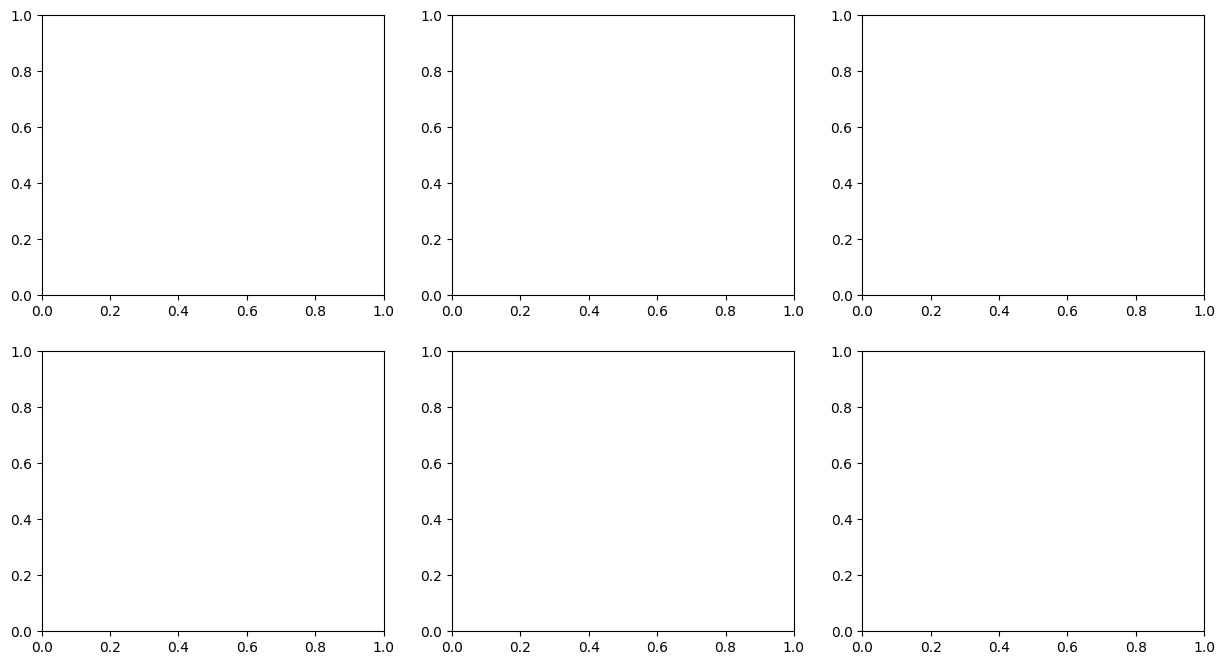

In [7]:
transformers = [
    ("TSNE with internal NearestNeighbors", TSNE(metric=metric, **tsne_params)),
    (
        "TSNE with KNeighborsTransformer",
        make_pipeline(
            KNeighborsTransformer(
                n_neighbors=n_neighbors, mode="distance", metric=metric
            ),
            TSNE(metric="precomputed", **tsne_params),
        ),
    ),
    (
        "TSNE with NMSlibTransformer",
        make_pipeline(
            NMSlibTransformer(n_neighbors=n_neighbors, metric=metric),
            TSNE(metric="precomputed", **tsne_params),
        ),
    ),
]

nrows = len(datasets)
ncols = np.sum([1 for name, model in transformers if "TSNE" in name])
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, squeeze=False, figsize=(5 * ncols, 4 * nrows)
)
axes = axes.ravel()
i_ax = 0

for dataset_name, (X, y) in datasets:
    msg = f"Benchmarking on {dataset_name}:"
    print(f"\n{msg}\n" + str("-" * len(msg)))

    for transformer_name, transformer in transformers:
        longest = np.max([len(name) for name, model in transformers])
        start = time.time()
        Xt = transformer.fit_transform(X)
        transform_duration = time.time() - start
        print(
            f"{transformer_name:<{longest}} {transform_duration:.3f} sec"
            " (fit_transform)"
        )

        # plot TSNE embedding which should be very similar across methods
        axes[i_ax].set_title(transformer_name + "\non " + dataset_name)
        axes[i_ax].scatter(
            Xt[:, 0],
            Xt[:, 1],
            c=y.astype(np.int32),
            alpha=0.2,
            cmap=plt.cm.viridis,
        )
        axes[i_ax].xaxis.set_major_formatter(NullFormatter())
        axes[i_ax].yaxis.set_major_formatter(NullFormatter())
        axes[i_ax].axis("tight")
        i_ax += 1

fig.tight_layout()
plt.show()

## Summary
In this lab, we learned how to use approximate nearest neighbors in TSNE using Python's scikit-learn library. We imported the required libraries, defined a wrapper class for nmslib, defined a function to load the MNIST dataset, benchmarked different nearest neighbors transformers, and visualized TSNE embeddings. We learned that the default TSNE estimator with its internal NearestNeighbors implementation is roughly equivalent to the pipeline with TSNE and KNeighborsTransformer in terms of performance. We also learned that the approximate NMSlibTransformer is already slightly faster than the exact search on the smallest dataset but this speed difference is expected to become more significant on datasets with a larger number of samples.